# Errors in Predicted Values

This is an attempt to use simulation to characterize the errors in predictions from two different methods of calculating coefficients (and then predicted values) for recentered data.

In principle, the predicted values from the original (uncentered) data/model should be exactly equal to the predicted values from a model estimated from the centered data.

Here we compare two different methods of generating model coefficients for recentered data.  In the first method, we actually recenter the data, then re-estimate the model, then calculate predicted values.  In the second method, we calculate the model coefficients directly, without re-estimating the model.  Then we calculate predicted values (using the same recentered data as in the first method).

The model is
$$ y = \beta_0 + \beta_1x_1 +\beta_2x_2 + \beta_3x_3 + \beta_4x_1x_2 + 
\beta_5x_1x_3 + \beta_6x_2x_3 + \beta_7x_1x_2x_3$$

In [4]:
# first load some useful functions
setwd("z:/r/stdParm-R")
source("stdParm functions.r") # for direct coefficient estimation
source("gen_ex_models.r")     # to generate simulated data
source("kd.plot.overlay.r")   # for plotting our results

### Main routine

- data simulation
- models estimation
- return difference in predicted values

In [5]:
sim.3var.center <- function (i, nvals) {
  df <- gen_3x(nvals, 
               means=c(-0.5,0,0.5),
               sigma=matrix(c(1,.5,.25,.5,1,.3,.25,.3,1), ncol=3),
               coefs=c(1,2,0,-2,.75,.5,.25,0))
  
  model1 <- lm(y~x1*x2*x3, data=df)
  
  b <- coef(model1)
  b.terms <- names(b)
  
  df2 <- df
  df2[,2:4] <- apply(df[,2:4],2,scale, scale=FALSE)
  model2 <- lm(y~x1*x2*x3, data=df2)
  
  x.means <- colMeans(df[,2:4])
  C <- matrix.build.clean(x.means, b.terms)
  
  y1 <- predict(model1) # original
  y2 <- predict(model2) # recentered data
  y3 <- cbind(rep(1,nvals), as.matrix(df2[2:4]),
              df2[["x1"]]*df2[["x2"]],df2[["x1"]]*df2[["x3"]],df2[["x2"]]*df2[["x3"]],
              df2[["x1"]]*df2[["x2"]]*df2[["x3"]])%*%(C%*%b)
  
  return(c(sqrt(sum((y1-y2)^2)),  # recenter data
           sqrt(sum((y1-y3)^2))))        # recenter coefs
}


## Simulation

- Numerical results:  first is recentered data, second is directly recentered coefficients
- Graphical results:  black is recentered data, red is directly recentered coefficients


[1] 1.386572e-14 6.699006e-15

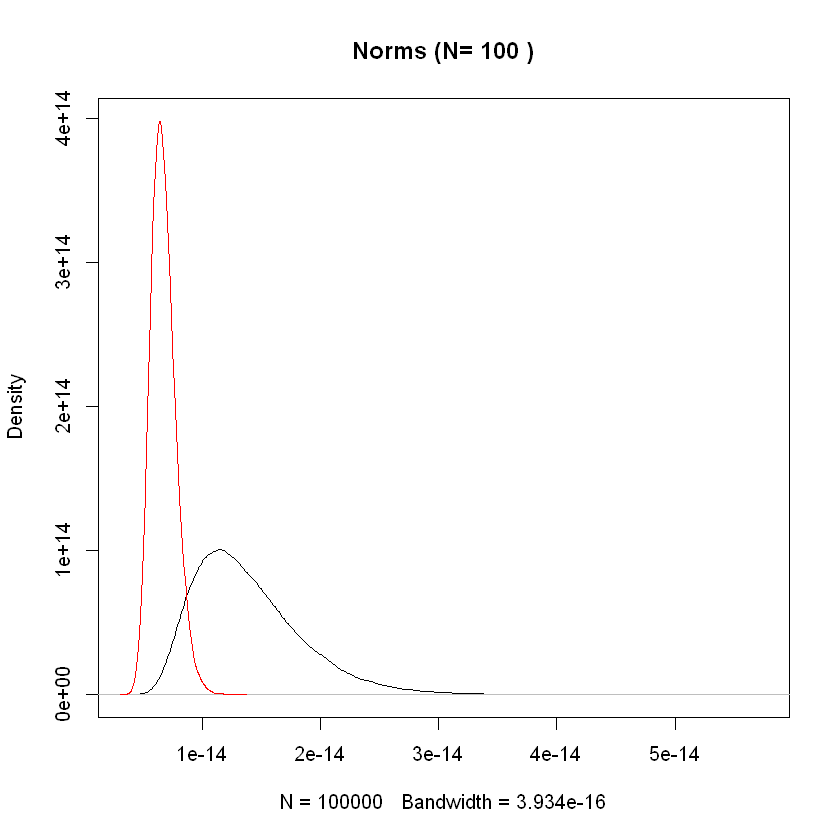

In [7]:
library(parallel)

cl <- makeCluster(8)

nvals <- 100L
clusterExport(cl, c("nvals", "sim.3var.center", "gen_3x", 
                    "mean.to.matrix", "matching.terms", "vars.in.terms", "kron", "matrix.build.clean"))
devnorms <- parSapply(cl, 1:100000, sim.3var.center, nvals)
rowMeans(devnorms)
kd.plot.overlay(t(devnorms), nvals)

[1] 6.385900e-14 2.137929e-14

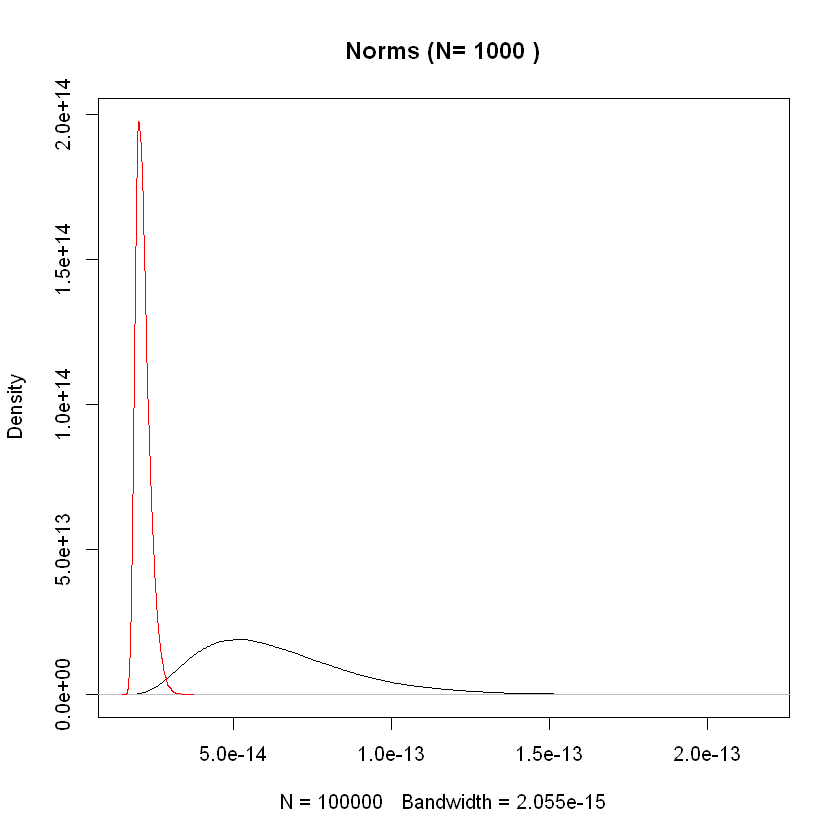

In [8]:
nvals <- 1000L
clusterExport(cl, c("nvals", "sim.3var.center", "gen_3x", 
                    "mean.to.matrix", "matching.terms", "vars.in.terms", "kron", "matrix.build.clean"))
devnorms <- parSapply(cl, 1:100000, sim.3var.center, nvals)
rowMeans(devnorms)
kd.plot.overlay(t(devnorms), nvals)

[1] 4.580411e-13 6.761701e-14

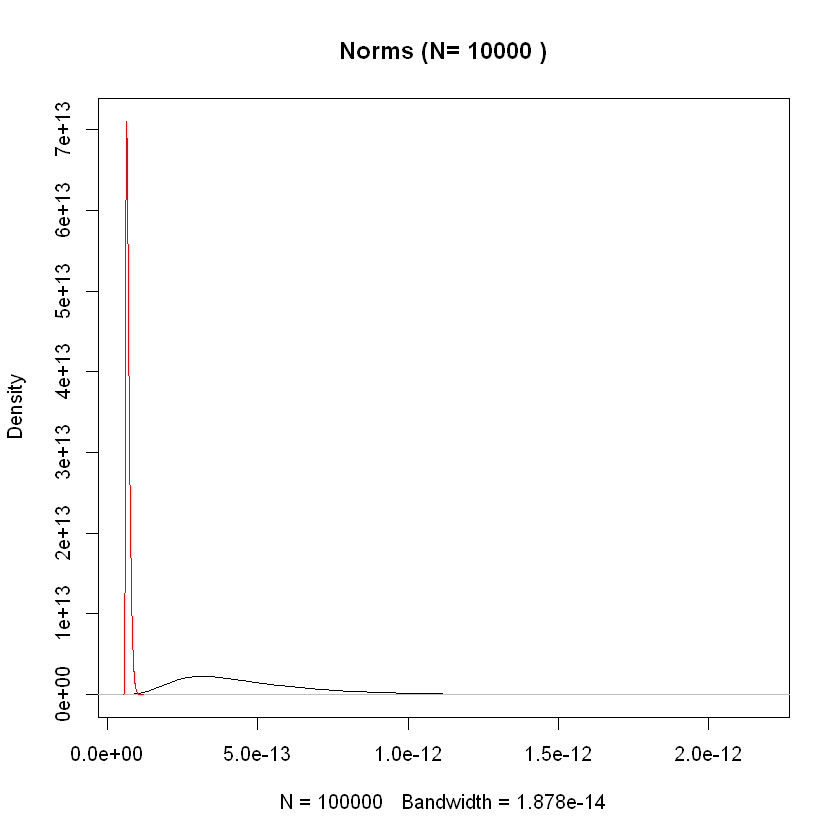

In [9]:
nvals <- 10000L
clusterExport(cl, c("nvals", "sim.3var.center", "gen_3x", 
                    "mean.to.matrix", "matching.terms", "vars.in.terms", "kron", "matrix.build.clean"))
devnorms <- parSapply(cl, 1:100000, sim.3var.center, nvals)
rowMeans(devnorms)
kd.plot.overlay(t(devnorms), nvals)

stopCluster(cl)